## 0. Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from implementations import * 
from proj1_helpers import *
from helpers import *
%load_ext autoreload
%autoreload 2

## 1. Load data

In [2]:
# just load the train data set
data_path = "../dataset/train.csv"
y_raw, x_raw, ids = load_csv_data(data_path)
y,x = equalize_predictions(y_raw,x_raw)


y.shape, x.shape

((171334,), (171334, 30))

In [59]:
_,data_u,ids_u = load_csv_data("../dataset/test.csv")


### clean data

In [82]:
x_clean,data_u_clean = clean_data(x,data_u)

#x_clean = fill_with_nan_list(x, nan_values=[0, -999])
#x = drop_corr_columns(x)

#data_u_clean = fill_with_nan_list(data_u,nan_values=[0,-999])

#x_clean = sustitute_nans(x_clean, substitutions=np.nanmean(x_clean, axis=0)) 
#data_u_clean = sustitute_nans(data_u_clean, substitutions=np.nanmean(data_u_clean, axis=0))

x_clean.shape,data_u_clean.shape

(6,)


((171334, 24), (568238, 24))

## 3. standardize (it won't consider the np.nan entries)

In [83]:
x_clean, mean_x, std_x = standardize(x_clean)
data_u_clean, mean_u,std_u = standardize(data_u_clean)
x_clean.shape, data_u_clean.shape

((171334, 24), (568238, 24))

## 4. either drop_nan_rows/column or substitute nan values with something meaningful

In [66]:
# check drop_nan_rows/columns and sustitute_nans in implementations.py
# np.nanmean(x, axis=0) should be an array of 0s (the column are standardized)
#x_clean = sustitute_nans(x_clean, substitutions=np.nanmean(x_clean, axis=0)) 
#data_u_clean = sustitute_nans(data_u_clean, substitutions=np.nanmean(data_u_clean, axis=0)) 

x_clean.shape, data_u_clean.shape

((171334, 30), (568238, 30))

## 5. train and test models:

### Ridge regression model selection

In [84]:

nb_lambdas = 20
degrees = range(6,12)
lambdas = np.linspace(1e-1,1e-10,nb_lambdas)
best_loss = 10**100
best_w =[]
best_lambda = 0
best_degree = 0

losses = []

for degree in degrees:
    tx = build_poly(x_clean,degree)
    losses_ = []
    for lambda_ in lambdas:
        loss, w = ridge_regression(y, tx, lambda_)
        if loss>0.32:
            loss=0.32
            
        losses_.append(loss)
        
        if loss<best_loss:
            best_loss = loss
            best_w = w
            best_lambda = lambda_
            best_degree = degree
    losses.append(losses_)        

losses = np.array(losses)
best_loss, best_degree, best_lambda

(0.2927290977064077, 9, 1e-10)

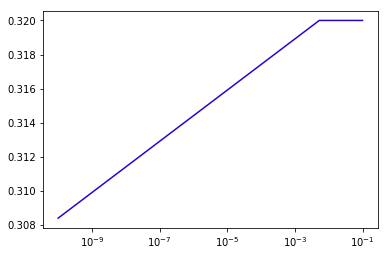

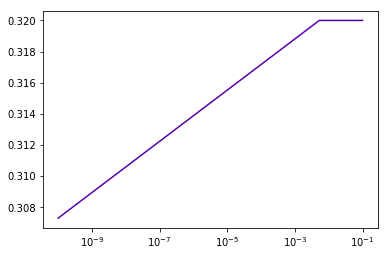

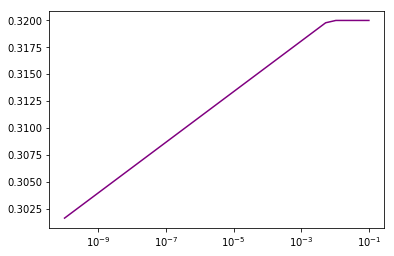

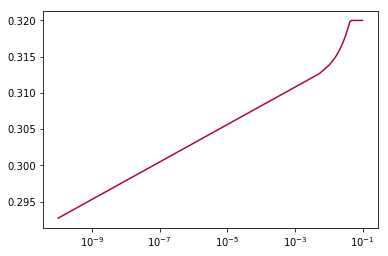

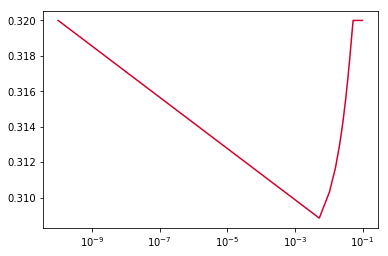

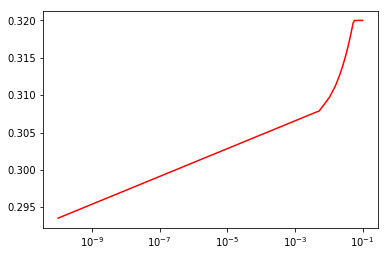

In [85]:
for losses_ in losses:
    for loss in losses_:
        if loss >0.32:
            loss = 0.32
r = 0
for losses_ in losses:
    r += 1/losses.shape[0]
    plt.semilogx(lambdas,losses_,color=(r,0.0,1-r))
    plt.show()
    

### Failed data analysis

In [29]:
predictions = predict_labels(best_w,tx)

failed_data = np.empty([0,x_clean.shape[1]])
success_data = failed_data

max_data = x_clean.shape[0]

idx_fail = 0
idx_success = 0

#while idx_fail < max_data or idx_success < max_data:
for idx in range(max_data):
    if predictions[idx] != y[idx]:
        failed_data=np.vstack((failed_data,x_clean[idx]))
        idx_fail+=1
    else:
        success_data=np.vstack((success_data,x_clean[idx]))
        idx_success +=1

        

failed_data.shape,success_data.shape,failed_data.shape[0]/x_clean.shape[0]

((13671, 30), (54669, 30), 0.20004389815627743)

In [ ]:
fail_means = np.mean(failed_data,axis=1)



### Failed data exportation

In [24]:
np.savetxt('../dataset/failed.csv', np.vstack((failed_data,success_data)), fmt='%s', delimiter=',')

### Learning curve analysis

In [69]:
test_train_ratios = [0.5]
train_data_ratios = np.linspace(0.1,0.99,100)

lambda_ = best_lambda
degrees = range(2,best_degree+1)

train_success_rates_matrix = np.zeros([len(degrees),len(train_data_ratios)])
test_success_rates_matrix = np.zeros([len(degrees),len(train_data_ratios)])
train_success_rates=[]
test_success_rates=[]

data_clean = x_clean

final_losses = []

best_loss = 10**100
best_w = []

for idx in range(len(degrees)):
    degree = degrees[idx]
    tx = build_poly(data_clean,degree)
    train_success_rates=[]
    test_success_rates=[]

    for tt_ratio in test_train_ratios:
        for t_data_ratio in train_data_ratios:
            test_start_idx = np.int_(data_clean.shape[0]*tt_ratio)
            train_stop_idx = np.int_(test_start_idx*t_data_ratio)

            tx_tr = tx[range(train_stop_idx)]
            y_tr = y[range(train_stop_idx)]

            tx_te = tx[range(test_start_idx,data_clean.shape[0])]
            y_te = y[range(test_start_idx,data_clean.shape[0])]

            loss, w = ridge_regression(y_tr, tx_tr, lambda_)

            if loss<best_loss:
                best_loss = loss
                best_w = w
                
            predictions_tr = predict_labels(w,tx_tr)
            predictions_te = predict_labels(w,tx_te)

            train_success_count =0
            test_success_count = 0

            for i in range(len(predictions_tr)):
                if predictions_tr[i]==y_tr[i]:
                    train_success_count+=1

            for i in range(len(predictions_te)):
                if predictions_te[i]==y_te[i]:
                    test_success_count+=1

            train_success_rates.append(train_success_count/len(predictions_tr))
            test_success_rates.append(test_success_count/len(predictions_te))

    final_losses.append(loss)
    
    train_success_rates_matrix[idx]=train_success_rates 
    test_success_rates_matrix[idx]=test_success_rates

train_success_rates_matrix.shape,test_success_rates_matrix.shape

((10, 100), (10, 100))

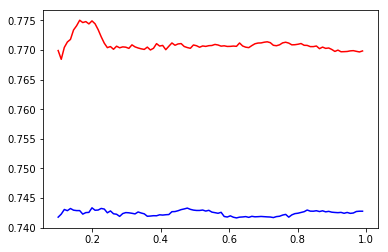

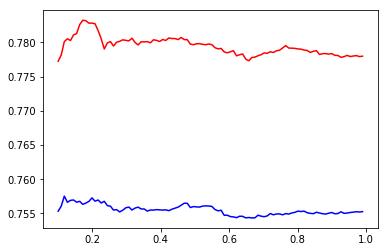

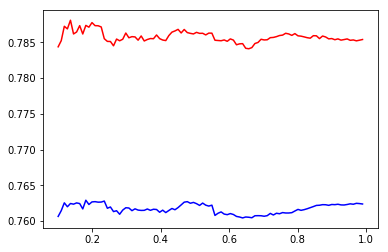

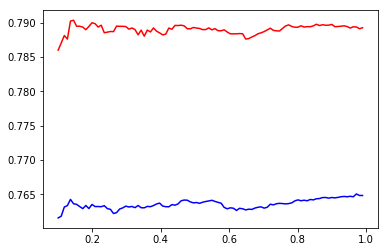

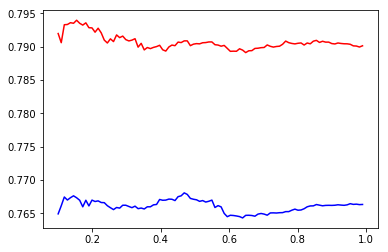

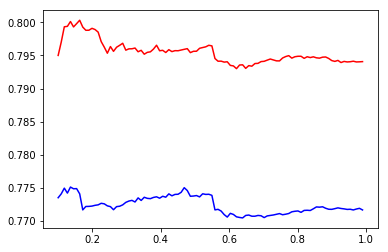

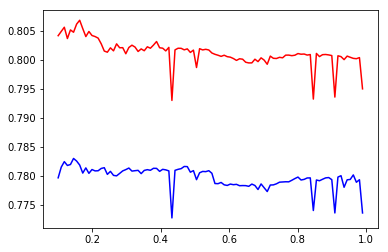

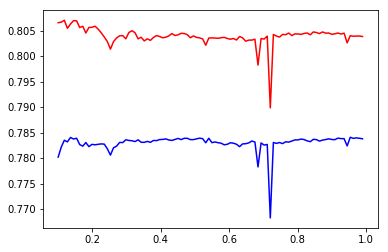

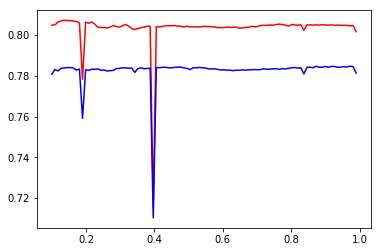

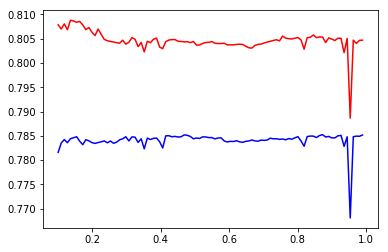

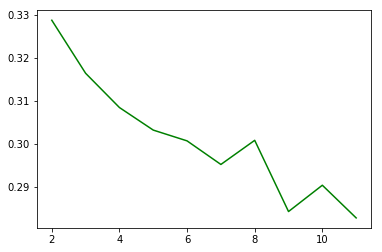

([0.3286727793674607,
  0.31634160457224009,
  0.30837688691176129,
  0.30312959077411983,
  0.30062149617494616,
  0.29513819902170169,
  0.30074991789007793,
  0.28418930473463094,
  0.29030751233003338,
  0.28270655130582661],
 0.27804732116851771,
 0.0052631579894736741)

In [72]:
for i in range(len(degrees)):
    plt.plot(train_data_ratios,train_success_rates_matrix[i],color='red')
    plt.plot(train_data_ratios,test_success_rates_matrix[i],color='blue')
    plt.show()
    #plt.savefig("ratios"+degree+".png")

plt.plot(degrees,final_losses, color = 'green')
plt.show()
final_losses,best_loss,best_lambda

### Distribution analysis

In [176]:
signal = np.empty([0,x_clean.shape[1]])
background = np.empty([0,x_clean.shape[1]])

for i in range(len(y)):
    if(y[i]==1):
        signal = np.vstack((signal,x_clean[i]))
    else:
        background = np.vstack((background,x_clean[i]))

signal.shape,background.shape

((34170, 18), (34170, 18))

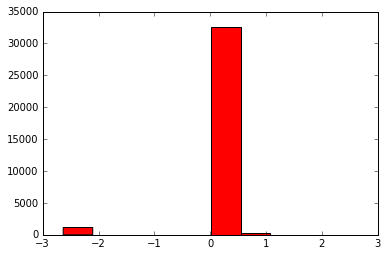

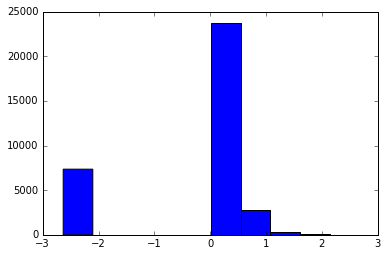

In [178]:

plt.hist(signal[:,0],color='red')
plt.show()
plt.hist(background[:,0],color='blue')
plt.show()

### Exportation

In [86]:

test_model_and_export(data_u_clean,ids_u,best_w,best_degree)

